https://www.kaggle.com/vaibhavsxn/time-series-multivariate-lstm

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load_dtypes()
# DF 불러올 때부터 축소해서 가져오는 함수.

def load_dtypes(file_path):
    print(file_path)
    tmp = pd.read_csv(file_path, nrows=0) # 애초에 파일을 불러올 때
    col_dtypes= {}
    for col in tmp.columns:
        df = pd.read_csv(file_path, usecols=[col]) # 애초에 파일을 불러올 때
        
        dtype = df[col].dtype
        
        if (dtype == 'int8' or dtype == 'int16' or dtype == 'int32' or dtype == 'int64'):
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'int'
            
        elif dtype == 'float32' or dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'float'
            
        elif dtype == 'object':
            n_unique = df[col].nunique()
            threshold = n_unique / df.shape[0]
            
        if dtype == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col_dtype = 'int8'
            elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                col_dtype = 'uint8'
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col_dtype = 'int16'
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                col_dtype = 'uint16'
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col_dtype = 'int32'
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                col_dtype = 'uint32'
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col_dtype = 'int64'
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                col_dtype = 'uint64'
                
        elif dtype == 'float':
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col_dtype = 'float32'
            else:
                col_dtype = 'float64'
                
        elif dtype == 'object':
            if threshold > 0.7:
                col_dtype = 'object'
            else:
                col_dtype = 'category'
                
        col_dtypes[col] = col_dtype
        

    df = pd.read_csv(file_path, dtype=col_dtypes)
    
    return df

In [2]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [4]:
train = load_dtypes(TRAIN_PATH)
train.info()

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [5]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.080002,-12,0.0
1,0,0,30,0,0,1.5,69.059998,-12,0.0
2,0,1,0,0,0,1.6,71.779999,-12,0.0
3,0,1,30,0,0,1.6,71.750000,-12,0.0
4,0,2,0,0,0,1.6,75.199997,-12,0.0


In [58]:
train = train.loc[:4800, ['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET']]

In [59]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,1.5,69.080002,-12,0.0
1,0,0,0,1.5,69.059998,-12,0.0
2,1,0,0,1.6,71.779999,-12,0.0
3,1,0,0,1.6,71.750000,-12,0.0
4,2,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...
4795,21,0,0,1.5,68.779999,3,0.0
4796,22,0,0,1.6,64.470001,3,0.0
4797,22,0,0,1.6,69.290001,2,0.0
4798,23,0,0,1.7,64.849998,2,0.0


In [121]:
train['target_1'] = train.TARGET.shift(48)
train['target_2'] = train.target_1.shift(48)

In [130]:
train = train.dropna()
train.shape

(4704, 9)

In [129]:
# 480개는 10일치입니다.
X = train[:-480]
y = train[-480:]
X.shape, y.shape

((4224, 9), (480, 9))

In [61]:
# lstm에 넣기 위해 스케일링을 합니다.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [62]:
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y)

In [63]:
# timeseriesGenerator를 씁니다.

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [64]:
# define generator
length = 96 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X, # train
                                scaled_X, # test
                                length=length,
                                batch_size=batch_size)

In [68]:
# length 만큼 줄어든 것을 알 수 있습니다.

len(scaled_X), len(generator)

(4320, 4224)

In [69]:
gen_X, gen_y = generator[0]

In [82]:
gen_X.size/7

96.0

In [81]:
gen_y.size

7

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [88]:
scaled_X.shape

(4320, 7)

In [89]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(64,input_shape=(length, # 96개로 들어갑니다.
                                scaled_X.shape[1]))) # 7개의 feature로 들어갑니다.

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_X.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18432     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 18,887
Trainable params: 18,887
Non-trainable params: 0
_________________________________________________________________


In [91]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=1)

validation_generator = TimeseriesGenerator(scaled_y,
                                           scaled_y, 
                                           length=length,
                                           batch_size=batch_size)

In [97]:
import tensorflow as tf

In [99]:

with tf.device('/cpu:0'):
    model.fit_generator(generator,
                        epochs=10,
                        validation_data=validation_generator,
                        callbacks=[early_stop])

Epoch 1/10
4222/4224 [============================>.] - ETA: 0s - loss: 0.0110WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002ADD0CE45E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4224/4224 [==============================] - 73s 17ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 2/10
4224/4224 [==============================] 

In [100]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

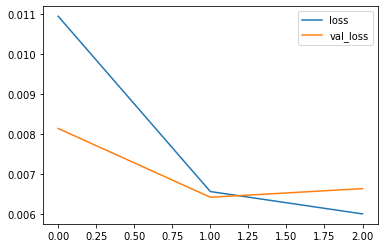

In [101]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [102]:
first_eval_batch = scaled_X[-length:]

In [103]:
first_eval_batch = first_eval_batch.reshape((1,
                                             length,
                                             scaled_X.shape[1]))

In [106]:
with tf.device('/cpu:0'):
    model.predict(first_eval_batch)

In [110]:
n_features = scaled_X.shape[1]
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

with tf.device('/cpu:0'):
    for i in range(len(y)):

        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.predict(current_batch)[0]

        # store prediction
        test_predictions.append(current_pred) 

        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [111]:
true_predictions = scaler.inverse_transform(test_predictions)

In [112]:
true_predictions

array([[ 1.56607719e+01, -9.32767600e+00, -1.93278893e+01, ...,
         5.32713678e+01,  9.09416350e+00, -3.06830993e+00],
       [ 9.47316480e+00, -1.55771325e+01, -3.43902736e+01, ...,
         5.50537745e+01,  8.73660860e+00, -4.47456446e+00],
       [ 5.60403191e+00, -2.16765454e+01, -5.21368117e+01, ...,
         5.67132177e+01,  8.52225648e+00, -5.17636961e+00],
       ...,
       [-5.10201502e+01, -7.17591459e+01, -3.26787652e+03, ...,
         1.93716837e+02,  8.48042832e+00, -1.51599940e+02],
       [-5.10201502e+01, -7.17591123e+01, -3.26787628e+03, ...,
         1.93716818e+02,  8.48042832e+00, -1.51599962e+02],
       [-5.10201557e+01, -7.17591661e+01, -3.26787628e+03, ...,
         1.93716818e+02,  8.48042975e+00, -1.51599962e+02]])

In [114]:
true_predictions = pd.DataFrame(data=true_predictions,columns=y.columns)
true_predictions

,Hour,DHI,DNI,WS,RH,T,TARGET
0,15.660772,-9.327676,-19.327889,2.833969,53.271368,9.094164,-3.068310
1,9.473165,-15.577132,-34.390274,2.937602,55.053774,8.736609,-4.474564
2,5.604032,-21.676545,-52.136812,3.000543,56.713218,8.522256,-5.176370
3,3.379457,-24.916280,-71.471876,3.062750,58.126571,8.355334,-5.790529
4,2.176428,-25.604989,-91.939483,3.118528,59.403303,8.223463,-6.513682
...,...,...,...,...,...,...,...
475,-51.020156,-71.759220,-3267.876520,15.106905,193.716856,8.480425,-151.599973
476,-51.020145,-71.759179,-3267.876035,15.106905,193.716856,8.480431,-151.599973
477,-51.020150,-71.759146,-3267.876520,15.106903,193.716837,8.480428,-151.599940
478,-51.020150,-71.759112,-3267.876278,15.106905,193.716818,8.480428,-151.599962


In [115]:
y

,Hour,DHI,DNI,WS,RH,T,TARGET
4320,0,0,0,2.9,52.779999,7,0.0
4321,0,0,0,3.0,56.549999,7,0.0
4322,1,0,0,3.1,54.430000,7,0.0
4323,1,0,0,3.0,54.410000,7,0.0
4324,2,0,0,2.9,54.130001,7,0.0
...,...,...,...,...,...,...,...
4795,21,0,0,1.5,68.779999,3,0.0
4796,22,0,0,1.6,64.470001,3,0.0
4797,22,0,0,1.6,69.290001,2,0.0
4798,23,0,0,1.7,64.849998,2,0.0
